# Figure 1: Athletes Brain Study - Refactored

This notebook demonstrates the refactored, modular approach to generating Figure 1 for the athletes brain study.
The analysis has been organized into reusable modules within the `athletes_brain.fig1` package.

## Setup and Imports

Import the refactored modules from our package.

In [1]:
# Standard imports
from pathlib import Path
import pandas as pd
import numpy as np

# Import our refactored modules
from athletes_brain.fig1 import (
    Fig1Config,
    AthletesBrainDataLoader,
    GroupComparison,
    BrainPlotter,
    generate_figure1,
)

# Import specific functions for focused analysis
from athletes_brain.fig1.main import analyze_specific_comparison, get_most_significant_regions

2025-08-20 15:05:27.497 | INFO     | athletes_brain.config:<module>:11 - PROJ_ROOT path is: /home/galkepler/Projects/athletes_brain


## Configuration

Set up the configuration and visualization settings.

In [2]:
# Initialize configuration
config = Fig1Config()
config.METRICS = ["gm_vol"]
# Set up matplotlib configuration for consistent plots
config.setup_matplotlib_config()

# Display configuration
print(f"Atlas: {config.ATLAS}")
print(f"Metrics: {config.METRICS}")
print(
    f"Group labels: {config.CLIMBER_GROUP_LABEL}, {config.BJJ_GROUP_LABEL}, {config.CONTROL_GROUP_LABEL}"
)
print(f"P-value threshold: {config.P_THRESHOLD}")
print(f"Visualization range: [{config.VMIN}, {config.VMAX}]")

Atlas: schaefer2018tian2020_400_7
Metrics: ['gm_vol']
Group labels: Climbing, Bjj, Control
P-value threshold: 0.05
Visualization range: [-5, 5]


## Quick Analysis: Generate Complete Figure 1

Use the main function to generate all comparisons and visualizations.

In [3]:
# Generate complete Figure 1
output_dir = Path("/media/storage/phd") / "athletes_brain" / "figures" / "behavioral"
output_dir.mkdir(parents=True, exist_ok=True)
# generate_figure1(output_dir=output_dir, config=config)

## Step-by-Step Analysis

For more control, we can run each step individually using the modular components.

### 1. Data Loading

In [4]:
# # Initialize data loader
# data_loader = AthletesBrainDataLoader(config)

# # Load all data
# metric_data, parcels, nifti_path, nifti_matlab_path = data_loader.load_all_data()

# print(f"Loaded {len(metric_data)} metrics")
# print(f"Loaded {len(parcels)} brain parcels")
# print(f"Metrics: {list(metric_data.keys())}")

# # Display sample data (demographics)
# df = metric_data["gm_vol"]
# df["subject_code"] = (
#     df["subject_code"]
#     .astype(str)
#     .str.replace("-", "")
#     .str.replace(" ", "")
#     .str.replace("_", "")
#     .str.zfill(4)
# )
# df = df.drop_duplicates(subset=["subject_code"], keep="first")

# print(f"N participants: {df.shape[0]}")

In [5]:
df_cov = pd.read_csv("~/Projects/plasticityhub/sessions.csv")
df_cov["subject_code"] = (
    df_cov["subject_code"]
    .astype(str)
    .str.replace("-", "")
    .str.replace(" ", "")
    .str.replace("_", "")
)
df_cov = df_cov.drop_duplicates(subset=["subject_code"])

In [16]:
# df_cov[df_cov["subject_code"] == "FNCL41"]["weekly_workouts"]
df_cov["filled"].value_counts()

filled
True     1851
False    1292
Name: count, dtype: int64

In [25]:
df_cov.loc[df_cov["filled"], "weekly_workouts"] = df_cov.loc[df_cov["filled"], "weekly_workouts"].fillna(0)
df_cov["weekly_workouts"] = df_cov["weekly_workouts"].replace({"10 שעות ויותר": 10})
df_cov.loc[df_cov["weekly_workouts"].notna(), "weekly_workouts"] = df_cov.loc[
    df_cov["weekly_workouts"].notna(), "weekly_workouts"
].astype(int)
df_cov = df_cov.dropna(subset=["weekly_workouts"])

/tmp/ipykernel_2645501/1875529829.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cov.loc[df_cov["filled"], "weekly_workouts"] = df_cov.loc[df_cov["filled"], "weekly_workouts"].fillna(0)
/tmp/ipykernel_2645501/1875529829.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cov["weekly_workouts"] = df_cov["weekly_workouts"].replace({"10 שעות ויותר": 10})


In [26]:
MAX_NUMBER_OF_WORKOUTS = 0

# write a query to detect atheletes (study == "sport", condition != "learning")
ATHLETES_QUERY = "(condition in ['Professional', 'Control']) & (group in ['Climbing', 'Bjj'])"
LEARNERS_QUERY = "(condition in ['Learning']) & (group in ['Climbing', 'Bjj'])"

target_subjects = df_cov.query(ATHLETES_QUERY)["subject_code"].unique()
learner_subjects = df_cov.query(LEARNERS_QUERY)["subject_code"].unique()

# locate subjects that have more than MAX_NUMBER_OF_WORKOUTS
subjects_to_drop = df_cov[
    (~df_cov["subject_code"].isin(target_subjects))
    & (~df_cov["subject_code"].isin(learner_subjects))
    & (df_cov["weekly_workouts"] > MAX_NUMBER_OF_WORKOUTS)
]["subject_code"].unique()
valid_learners = df_cov[
    (df_cov["subject_code"].isin(learner_subjects))
    & (df_cov["weekly_workouts"] <= MAX_NUMBER_OF_WORKOUTS)
]["subject_code"].unique()

In [27]:
df_cov["target"] = df_cov["subject_code"].isin(target_subjects)
df_cov["learner"] = df_cov["subject_code"].isin(learner_subjects)
df_cov["cs_valid"] = True
df_cov.loc[
    (df_cov["learner"]) & (~df_cov["target"]) & (~df_cov["subject_code"].isin(valid_learners)),
    "cs_valid",
] = False
# drop "subjects_to_drop"
df_cov = df_cov[~df_cov["subject_code"].isin(subjects_to_drop)]

In [28]:
df_cov = df_cov.dropna(subset=["target"])

In [29]:
df_cov["target"] = df_cov["target"].astype(str)
df_cov["sex"] = df_cov["sex"].astype(str)
df_cov["age_c"] = df_cov["age_at_scan"] - df_cov["age_at_scan"].mean()
df_cov["BMI"] = df_cov["weight"] / ((df_cov["height"] / 100) ** 2)

### 2. Statistical Analysis

In [30]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf


def class_balance_weights(s, target_mix=None):
    # s: Series with values "True"/"False" for athlete/control (strings)
    p_obs = s.value_counts(normalize=True).to_dict()
    if target_mix is None:
        target_mix = {"True": 0.5, "False": 0.5}  # choose your target mix
    return s.map(lambda g: target_mix[g] / p_obs[g])


def analyze_with_class_weights(df, target_mix=None, robust=None, metric: str = "adc"):
    d = df.dropna(subset=["value", "target", "sex", "age_at_scan"]).copy()
    d["target"] = d["target"].astype(str)
    d["sex"] = d["sex"].astype(str)
    d["age_c"] = d["age_at_scan"] - d["age_at_scan"].mean()
    w = class_balance_weights(d["target"], target_mix=target_mix)

    formula = "value ~ C(target, Treatment(reference='False')) " "+ C(sex) + age_c + I(age_c**2)"
    if "vol" in metric:
        formula += " + tiv"

    fit = smf.wls(formula, data=d, weights=w).fit(cov_type=(robust or "nonrobust"))

    # effect (athletes vs controls) is the coefficient on the target indicator:
    coef_name = [k for k in fit.params.index if k.startswith("C(target")][0]
    t = fit.tvalues[coef_name]
    df_r = fit.df_resid
    r_partial = np.sign(t) * np.sqrt(t**2 / (t**2 + df_r))
    r2_partial = t**2 / (t**2 + df_r)
    out = {
        "target_mix": target_mix or {"True": 0.5, "False": 0.5},
        "coef_delta": float(fit.params[coef_name]),
        "t": float(t),
        "r_partial": float(r_partial),
        "r2_partial": float(r2_partial),
        "ci95": tuple(map(float, fit.conf_int().loc[coef_name])),
        "p_value": float(fit.pvalues[coef_name]),
        "n": len(d),
        # effective n is useful to report with weights:
        "effective_n": float((w.sum() ** 2) / (w.pow(2).sum())),
    }
    return out, fit

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

behav_columns = [
    "BMI",
    "salary",
    "pcl5",
    "sos_q",
    # "weekly_workouts",
    "psychometric_score",
    "swls",
    "hli",
    "gad7",
    "psqi",
    "oasis",
    "phq9",
    "screen_time",
    "smartphone_usage",
    "home_cooking_times_per_week",
    "working_with_computer_times_per_week",
    "recreational_activity_times_per_week",
    "water",
    "alcohol",
    "sugar_beverages"
]


behav_vis = {
    "BMI": "BMI",
    "salary": "Salary",
    "pcl5": "PCL-5 (PTSD)",
    "sos_q": "SOS-Q",
    "psychometric_score": "Psychometric Score",
    "swls": "SWLS (Satisfaction)",
    "hli": "HLI (Health Life Index)",
    "gad7": "GAD-7 (Generalized Anxiety Disorder)",
    "psqi": "PSQI (Sleep)",
    "oasis": "OASIS (Anxiety)",
    "phq9": "PHQ-9 (Depression)",
    "screen_time": "Screen Time",
    "smartphone_usage": "Smartphone Usage",
    "home_cooking_times_per_week": "Home Cooking (times/week)",
    "working_with_computer_times_per_week": "Working with Computer (times/week)",
    "recreational_activity_times_per_week": "Recreational Activity (times/week)",
    "water": "Water (cups/day)",
    "alcohol": "Alcohol (drinks/week)",
    "sugar_beverages": "Sugar Beverages (drinks/week)"
}

domains = {
    "BMI": "Physical Health",
    "salary": "Socioeconomic Status",
    "pcl5": "Mental Health",
    "sos_q": "Mental Health",
    "psychometric_score": "Mental Health",
    "swls": "Mental Health",
    "hli": "Mental Health",
    "gad7": "Mental Health",
    "psqi": "Mental Health",
    "oasis": "Mental Health",
    "phq9": "Mental Health",
    "screen_time": "Lifestyle",
    "smartphone_usage": "Lifestyle",
    "home_cooking_times_per_week": "Lifestyle",
    "working_with_computer_times_per_week": "Lifestyle",
    "recreational_activity_times_per_week": "Lifestyle",
    "water": "Lifestyle",
    "alcohol": "Lifestyle",
    "sugar_beverages": "Lifestyle"
}

results_template = pd.DataFrame(columns=["target_col", "vis_col", "domain", "coef_delta", "t", "r_partial", "r2_partial", "ci95_lo","ci95_hi", "p_value", "n_controls", "n_athletes"])
results = {}

for group in ["all","climbing","bjj"]:
    results[group] = results_template.copy()
    for i,target_col in enumerate(behav_columns):
        d = df_cov.dropna(subset=[target_col])
        d = d[d["cs_valid"]]
        if group != "all":
            d = d.drop(d[(d["target"] == "True") & (d["group"].str.lower() != group)].index)
        # d = d.drop(d[(d["target"] == "True") & (d["group"].str.lower() == "bjj")].index)

        w = class_balance_weights(d["target"].astype(str))


        fit = smf.wls(
            f"{target_col} ~ C(target, Treatment(reference='False')) + C(sex) + age_c + I(age_c ** 2)",
            data=d,
            weights=w,
        ).fit()
        fit.summary()

        # get "clean" coefficients for plotting
        coef_name = [k for k in fit.params.index if k.startswith("C(target")][0]
        coef = fit.params[coef_name]
        t = fit.tvalues[coef_name]
        df_r = fit.df_resid
        r_partial = np.sign(t) * np.sqrt(t**2 / (t**2 + df_r))
        r2_partial = t**2 / (t**2 + df_r)
        n_control = d[d["target"] == "False"].shape[0]
        n_athlete = d[d["target"] == "True"].shape[0]

        results[group].loc[i] = [target_col, behav_vis.get(target_col, target_col), domains.get(target_col, ""), coef, t, r_partial, r2_partial, coef - 1.96 * fit.bse[coef_name], coef + 1.96 * fit.bse[coef_name], fit.pvalues[coef_name], n_control, n_athlete]


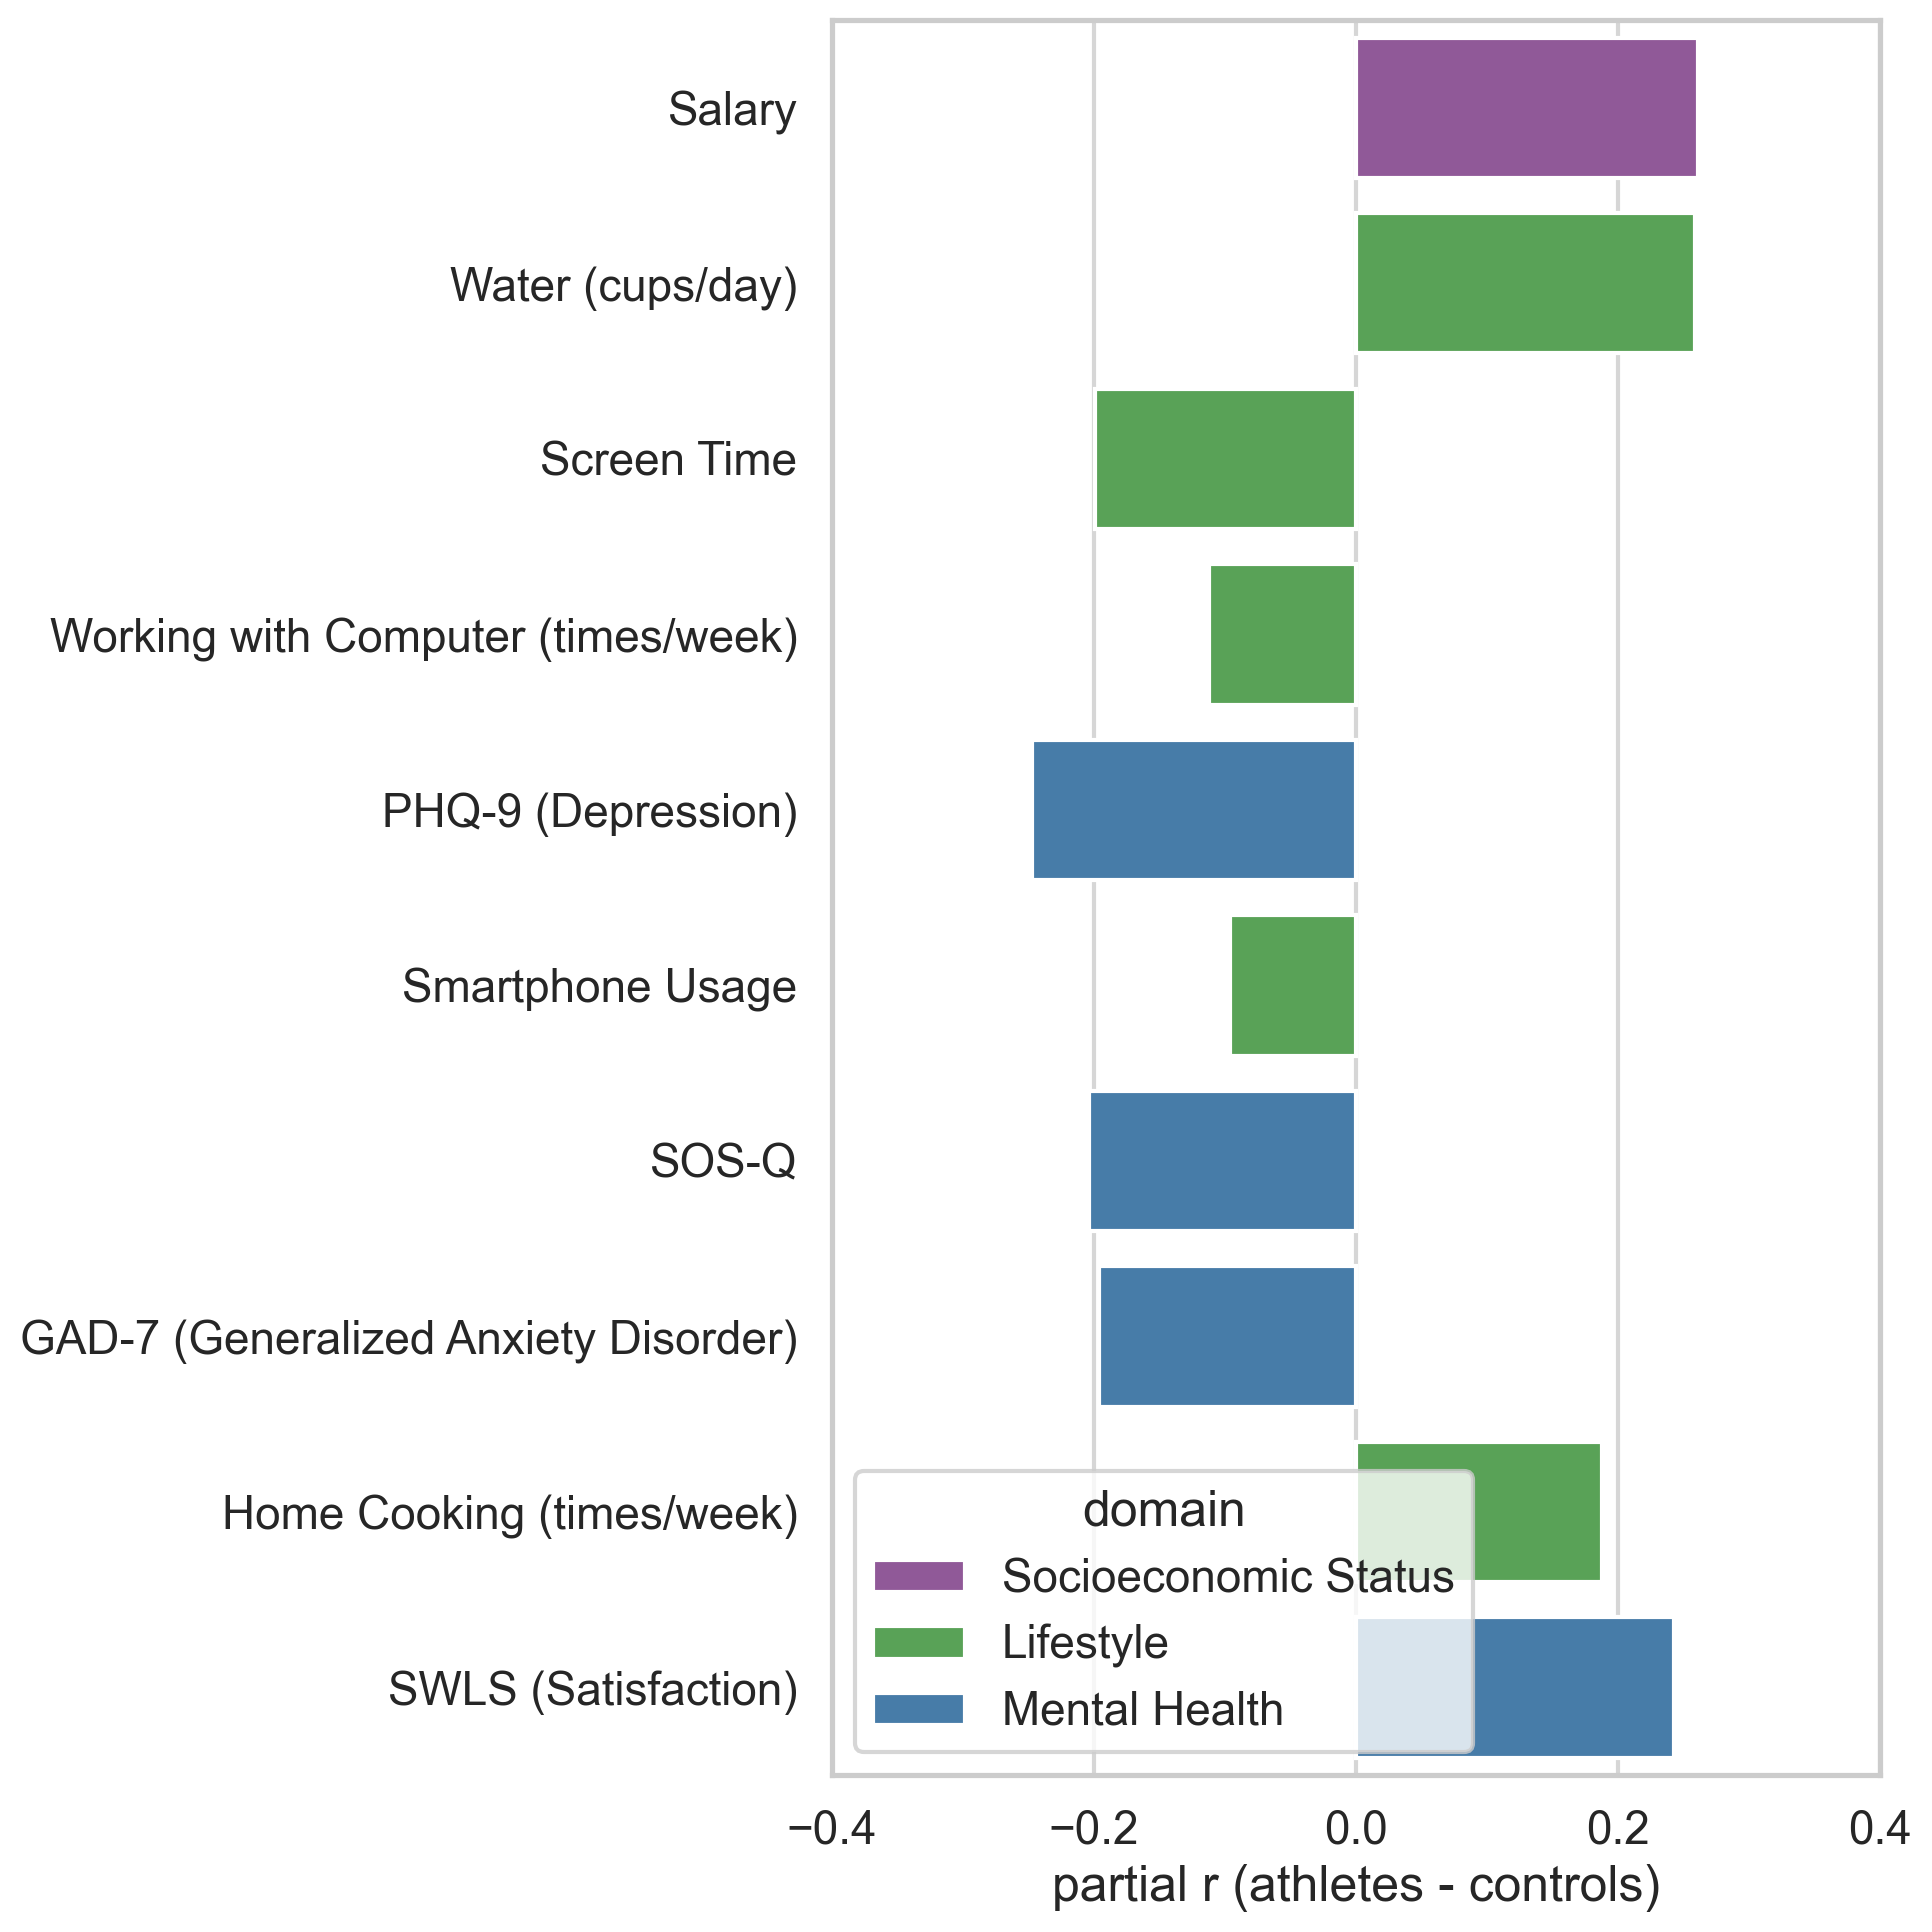

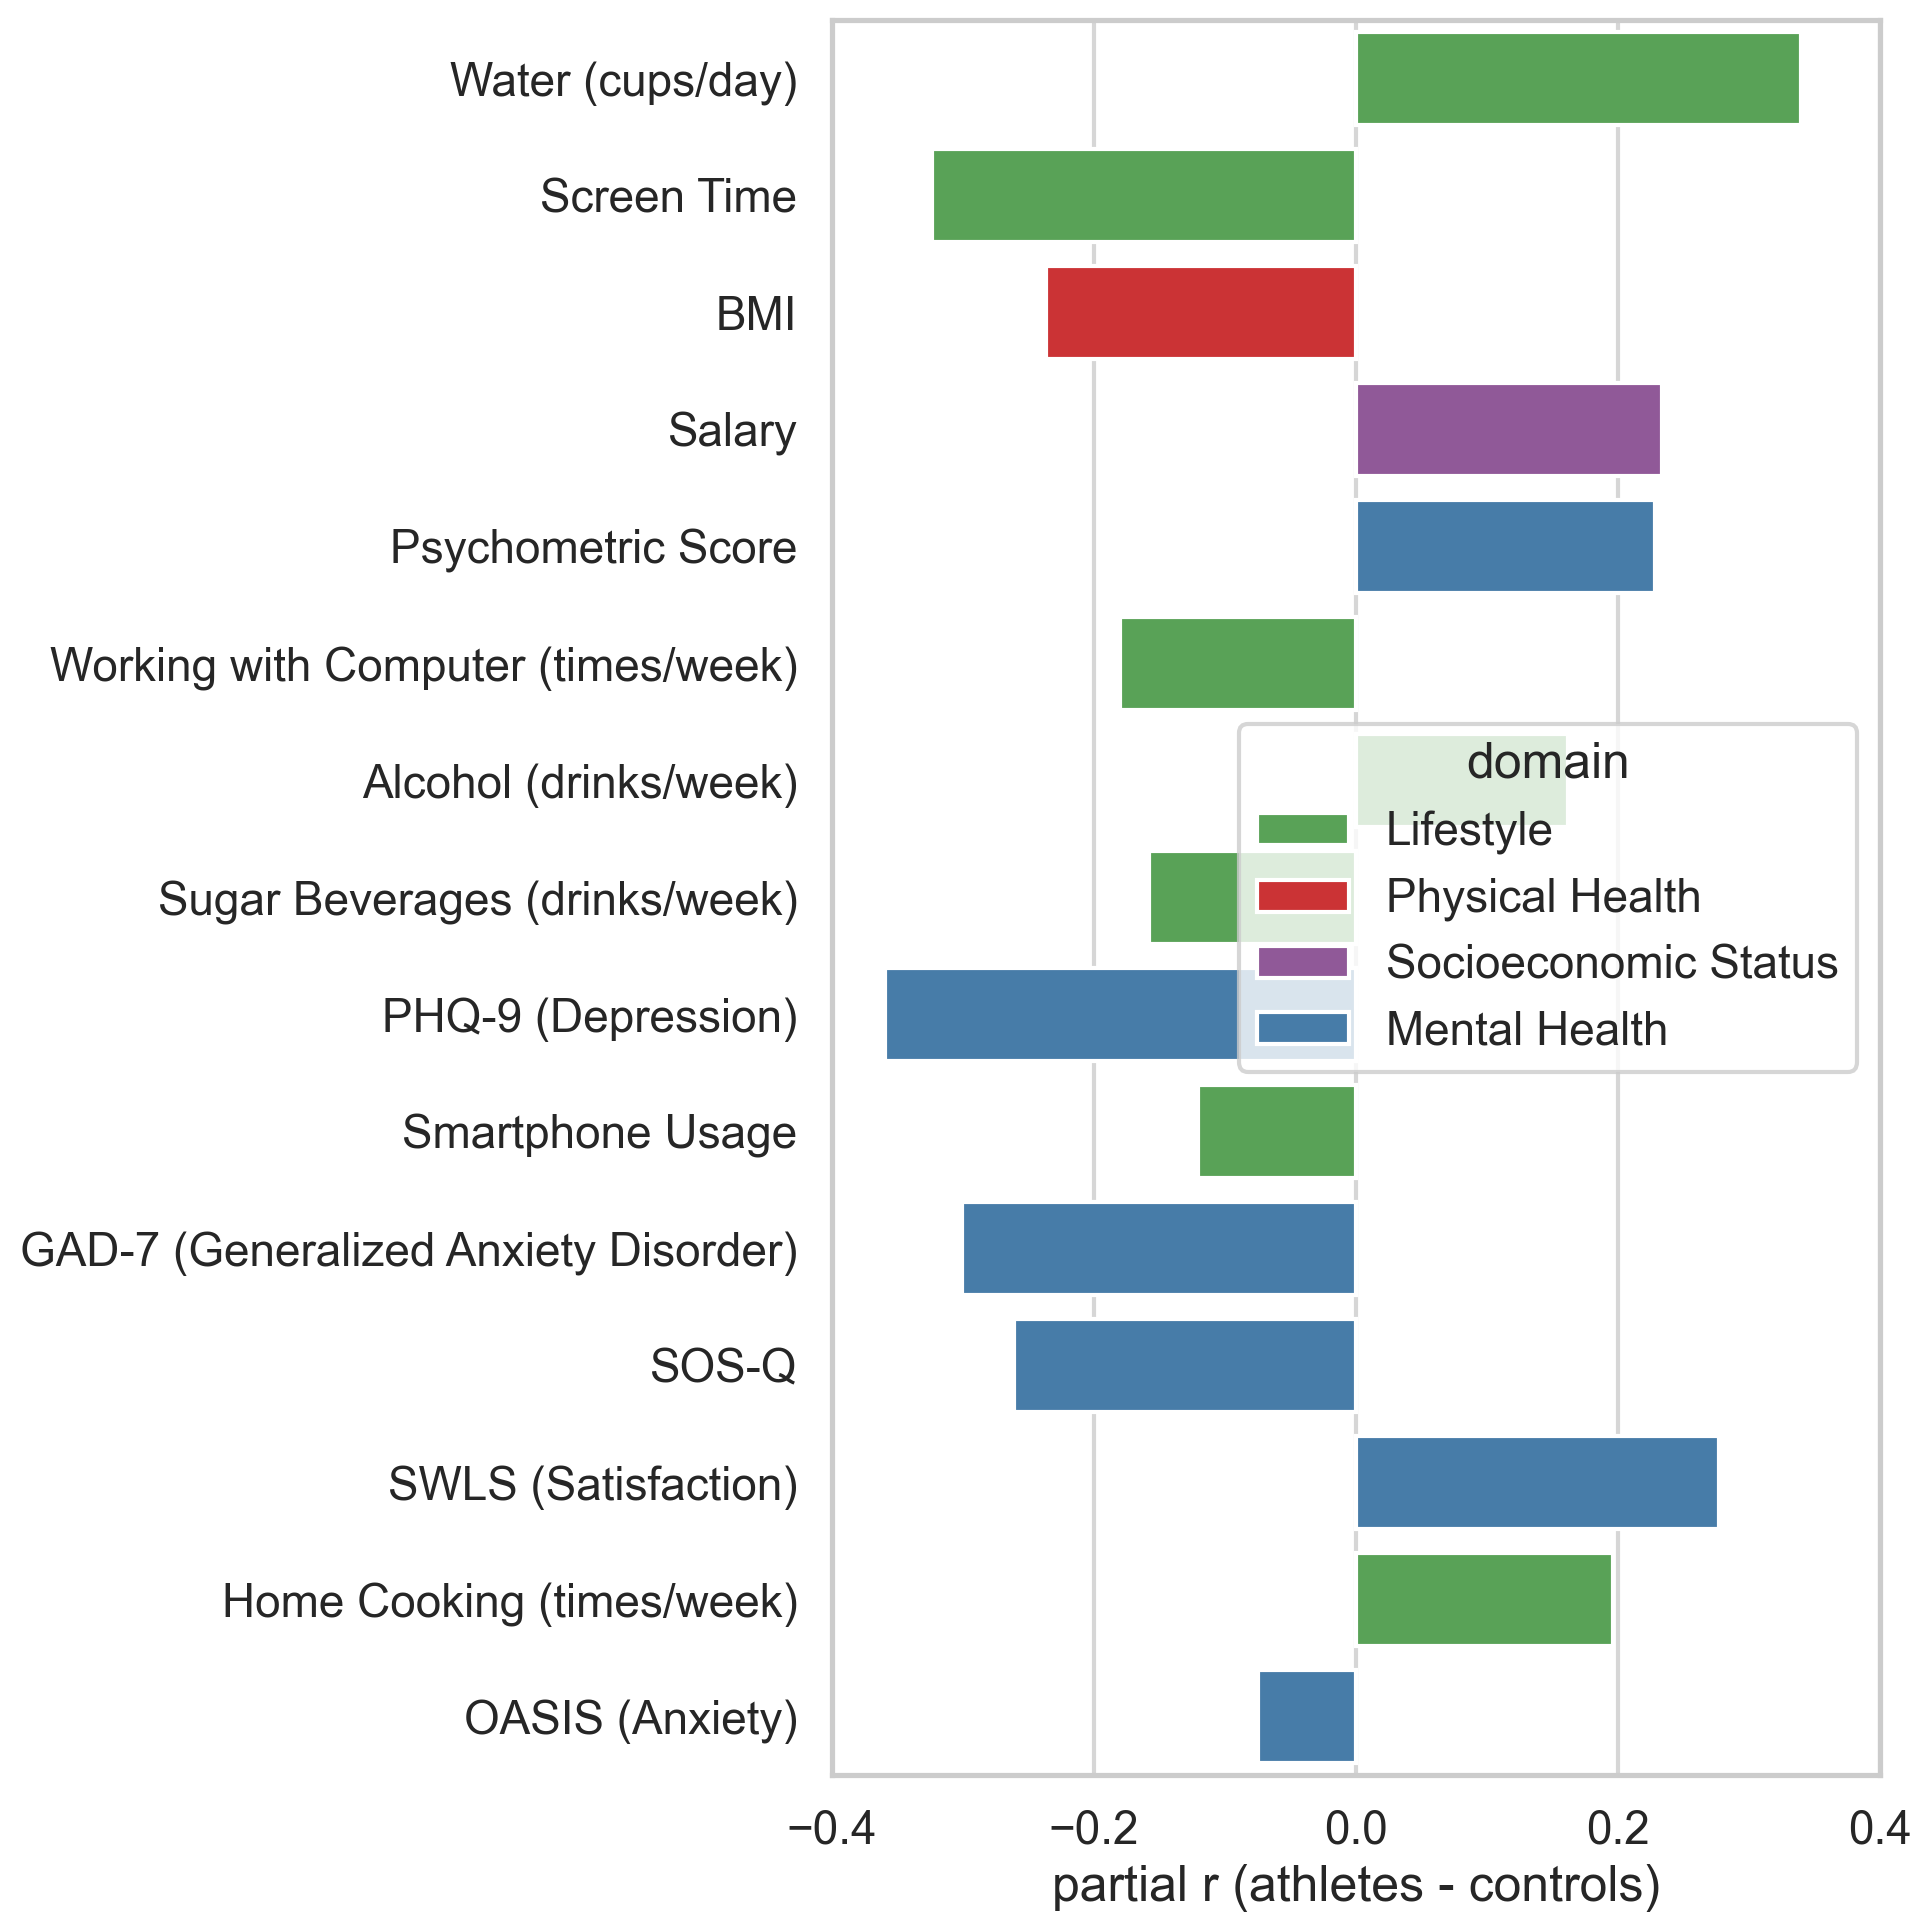

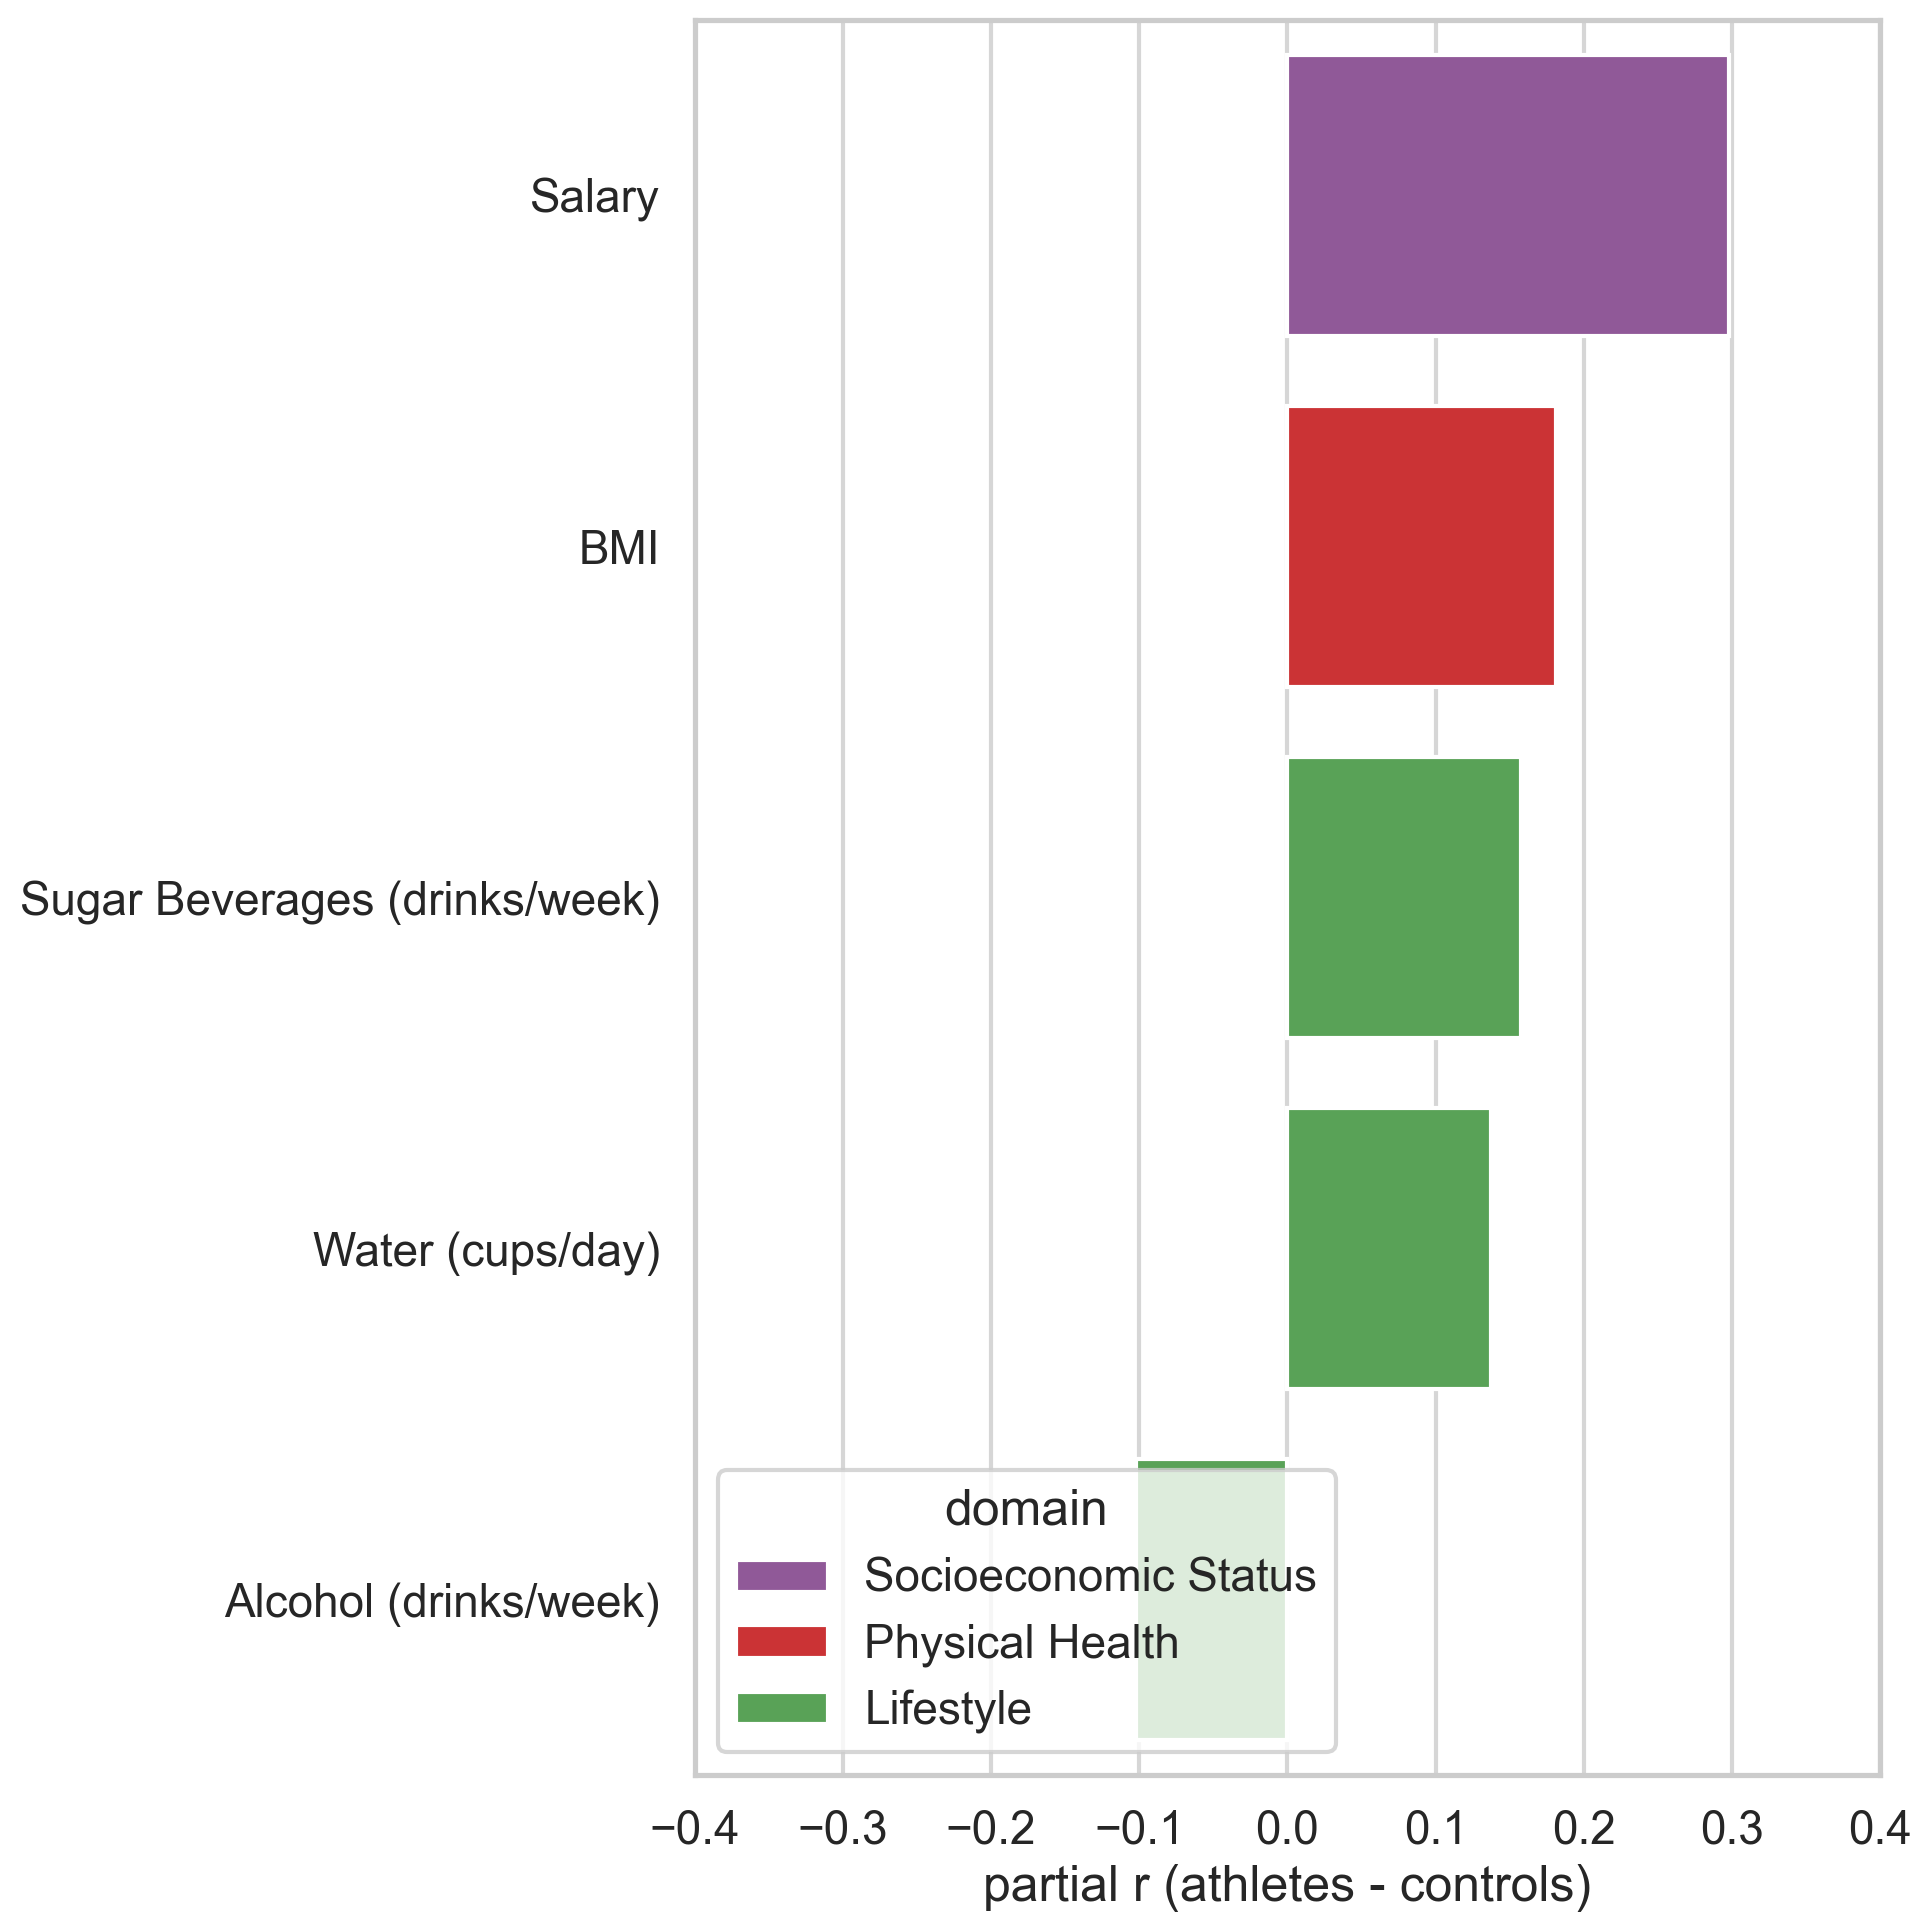

In [32]:
from athletes_brain.fig1.config import savefig_nice
import matplotlib as mpl

cmap = "Set1"

cmap = mpl.colormaps.get(cmap, 10)

domain_colors = {
    "Physical Health": cmap(0),
    "Mental Health": cmap(1),
    "Lifestyle": cmap(2),
    "Socioeconomic Status": cmap(3)
}


for group in ["all","climbing","bjj"]:
    vis = results[group].sort_values("p_value")
    # results
    fig, ax = plt.subplots(figsize=(10, 10))
    ax = sns.barplot(x="r_partial", y="vis_col", data=vis[vis["p_value"] < 0.05], ax=ax, hue="domain", palette=domain_colors)
    # ax.set_title("Behavioral differences between athletes and controls")
    ax.set_xlabel("partial r (athletes - controls)")
    ax.set_ylabel("")
    ax.set_xlim(-0.4, 0.4)

    savefig_nice(fig, output_dir / f"{group}.png", dpi=400)